# Домашнее задание. Классификация изображений

Сегодня вам предстоить помочь телекомпании FOX в обработке их контента. Как вы знаете, сериал "Симпсоны" идет на телеэкранах более 25 лет, и за это время скопилось очень много видеоматериала. Персоонажи менялись вместе с изменяющимися графическими технологиями, и Гомер Симпсон-2018 не очень похож на Гомера Симпсона-1989. В этом задании вам необходимо классифицировать персонажей, проживающих в Спрингфилде. Думаю, нет смысла представлять каждого из них в отдельности.



### Установка зависимостей

В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [1]:
import pickle
import numpy as np
from skimage import io
import pandas as pd

from tqdm import tqdm, tqdm_notebook, trange
from PIL import Image
from pathlib import Path

from torchvision import transforms, models
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch

import math
import copy

from matplotlib import colors, pyplot as plt
%matplotlib inline

import seaborn as sns

sns.set_style('darkgrid')
# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [2]:
SEED = 0
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(SEED)

In [3]:
# DATA_DIR = "data/"
DATA_DIR = "../input/journey-springfield/"
N_CORES = 2

In [4]:
BATCH_SIZE = 128
RESCALE_SIZE = 224
DATA_MODES = ['train', 'val', 'test']
DEVICE = torch.device("cpu")

if torch.cuda.is_available():
    print('CUDA is available! Training on GPU...')
    DEVICE = torch.device("cuda")
else:
    print('CUDA is not available. Training on CPU...')

CUDA is not available. Training on CPU...


In [5]:
TRAIN_DIR = Path(DATA_DIR + 'train/simpsons_dataset')
TEST_DIR = Path(DATA_DIR + 'testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
train_val_labels = [path.parent.name for path in train_val_files]
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))
N_CLASSES = len(np.unique(train_val_labels))

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation. 

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample) 

Добавим в исходных класс аугментацию данных. Для этого я использую библиотеку Albumentations, ее функционал может полностью заменить torchvision, и она более оптимизована (доверяюсь информации из статьи, сам не проверял) Для интересующихся вот статья: https://towardsdatascience.com/data-augmentation-for-deep-learning-4fe21d1a4eb9

In [6]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

ModuleNotFoundError: No module named 'albumentations'

In [ ]:
# Пишу специально класс для padding, так как необходимо переопределить метод __call__ для написания собственного
# трансформера
class SquarePad:
    def __call__(self, image):
        image = Image.fromarray(image)
        w, h = image.size
        max_wh = np.max([w, h])
        hp = int((max_wh - w) / 2)
        vp = int((max_wh - h) / 2)
        padding = (hp, vp, hp, vp)
        aug = transforms.functional.pad(image, padding, 0, 'constant')
        return {'image': np.array(aug)}
        
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
    
    # Я использую библиотеку albumentations, а она плохо работает с PIL. Необходим костыль в плане перевода
    # изображения в np.darray
    def transform(self, image, transformer):
        np_image = np.array(image)
        augmented = transformer(image = np_image)
        return augmented['image']
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform_val_test = A.Compose([
            A.Resize(RESCALE_SIZE, RESCALE_SIZE),
            A.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]),
            ToTensorV2()
        ])
        # для аугментации изображений из train
        transform_train = A.Compose([
            SquarePad(),
            A.HorizontalFlip(p = 0.5),
            A.OneOf([
                # apply one of transforms to 50% of images
                A.Rotate(limit = 30),
                A.RandomGamma() # apply random gamma
            ], p = 0.5),
            A.Resize(300, 300),
            A.OneOf([
                A.RandomCrop(250, 250),
                A.CenterCrop(250, 250)
            ], p = 0.5),
            A.Resize(RESCALE_SIZE, RESCALE_SIZE),
            A.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]),
            ToTensorV2(),
        ])
        x = self.load_sample(self.files[index])
        if self.mode == 'train':
            x = self.transform(x, transform_train)
        else:
            x = self.transform(x, transform_val_test)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [ ]:
from sklearn.model_selection import train_test_split

train_files, val_files = train_test_split(train_val_files, test_size=0.25, stratify=train_val_labels)

In [15]:
val_dataset = SimpsonsDataset(val_files, mode='val')
train_dataset = SimpsonsDataset(train_files, mode='train')

Давайте посмотрим на наших героев внутри датасета.

Выведем сначала изображения без аугментации

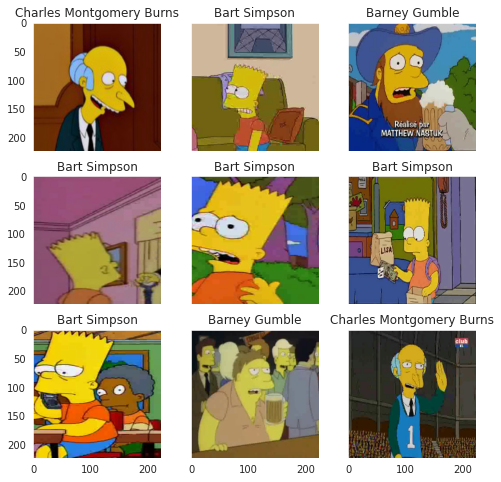

In [16]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

А теперь с аугментацией. Интересно получается :)

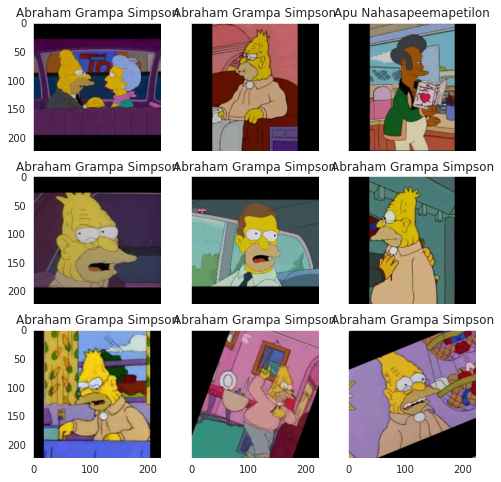

In [17]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = train_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                train_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

### Балансировка 

In [18]:
# Переведем все наши данные в лист, так как наш класс Simpson Dataset на каждом вызове getitem читает изображение
# с файла, что очень времязатратно. Эта функция позволяет ускорить обучение в 3-4 раза в моем случае
# Небольшой костыль - возвращаю list для дальнейшего обучения и np.array чтобы легче отображать определенные изображения
def simpson_dataset_to_numpy(dataset):
    labels = np.zeros(len(dataset))
    images = torch.zeros(len(dataset), 3, 224, 224)
    for i, (image, label) in enumerate(tqdm(dataset)):
        labels[i] = label
        images[i] = image
    return list(zip(images, labels)), np.array(list(zip(images, labels)))

In [19]:
lst_train_dataset, np_train_dataset = simpson_dataset_to_numpy(train_dataset)
# Можно сделать такую же операцию с val , но памяти не хватает 
#lst_val_dataset, np_val_dataset = simpson_dataset_to_numpy(val_dataset)

100%|██████████| 15699/15699 [03:01<00:00, 86.66it/s] 
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


In [20]:
# Эту функцию я делал для проверки аугментации для редких классов, так как далее мы будем делать балансировку,
# где наши редкие изображения будут дублироваться, поэтому при нелепой или сложной аугментации модель не 
# сможет распознавать нормальные изображения
def show_low_classes_img(dataset):
    count = pd.Series(dataset[:,1]).value_counts().sort_values().to_frame('Count')
    print(count)
    labels_low_num_classes = np.array(count[count.values < 20].index)
    for i, low_class in enumerate(labels_low_num_classes):
        axes = plt.subplots(nrows=math.ceil(count.values[i]/4), ncols=4, figsize=(12, 9))[1]
        x, y = dataset[dataset[:,1] == low_class][:,0], dataset[dataset[:,1] == low_class][:,1]
        for ax, d, l in zip(axes.flatten(), x, y):
            imshow(d, title=low_class, plt_ax=ax)

      Count
19.0      2
40.0      6
10.0      6
26.0     13
13.0     20
12.0     20
30.0     24
38.0     30
1.0      32
34.0     34
8.0      35
39.0     41
33.0     49
23.0     53
31.0     54
35.0     67
5.0      74
36.0     77
3.0      80
14.0     91
21.0     96
41.0    136
24.0    185
18.0    233
29.0    269
11.0    343
9.0     352
16.0    373
2.0     467
37.0    658
0.0     685
7.0     739
25.0    809
6.0     895
32.0    895
17.0    904
22.0    968
4.0    1006
20.0   1015
27.0   1089
28.0   1090
15.0   1684


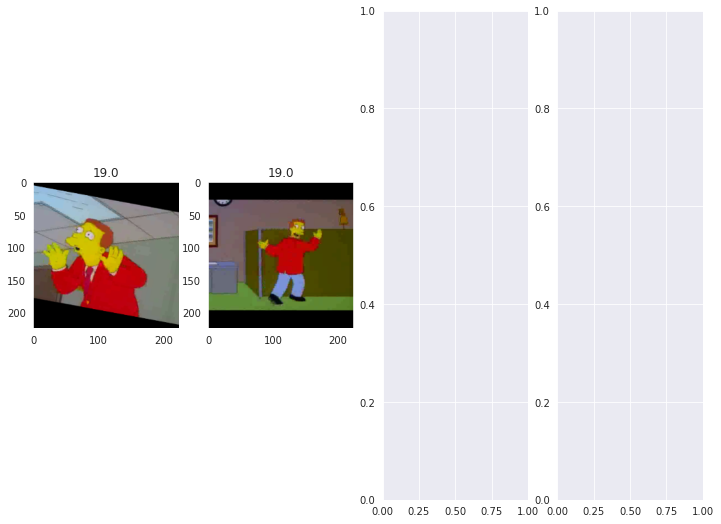

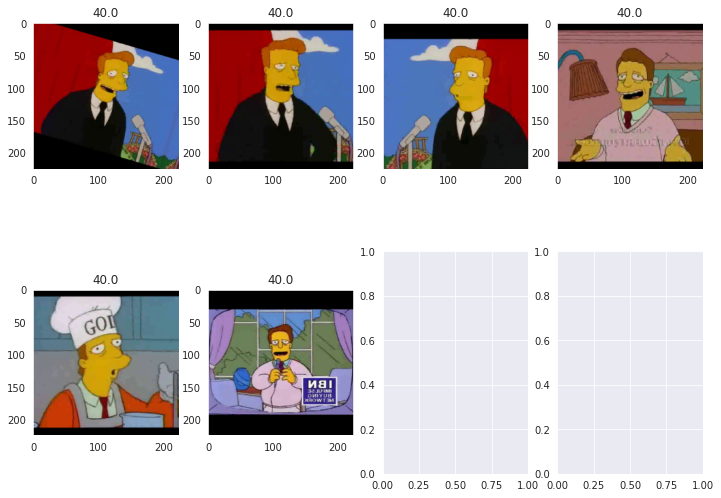

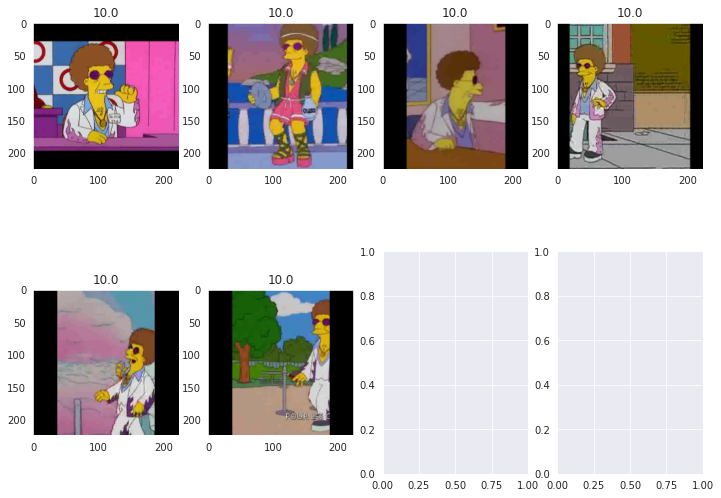

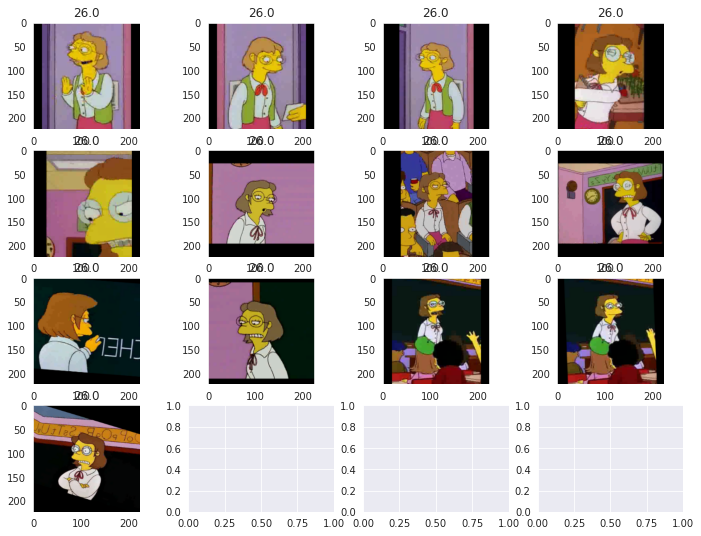

In [21]:
show_low_classes_img(np_train_dataset)

In [22]:
# Получаем кол-во изображений в каждом классе для балансировки
train_labels = [lst_train_dataset[i][1] for i, _ in enumerate(lst_train_dataset)]
targets = np.unique(train_labels, return_counts=True)[1]
targets

array([ 685,   32,  467,   80, 1006,   74,  895,  739,   35,  352,    6,
        343,   20,   20,   91, 1684,  373,  904,  233,    2, 1015,   96,
        968,   53,  185,  809,   13, 1089, 1090,  269,   24,   54,  895,
         49,   34,   67,   77,  658,   30,   41,    6,  136])

In [23]:
weights = 1 / targets
dict_weights = {}
for i, weight in enumerate(weights):
    dict_weights[i] = weight
weight_sampler = train_labels.copy()
for i, label in enumerate(train_labels):
    weight_sampler[i] = dict_weights[label]
assert len(train_labels) == len(weight_sampler)

In [24]:
# Используем WeightedRandomSampler, каждый класс дополним копиями до максимального количества картинок в классе
# то есть Bart Simpson = 2к примерно, соответственно все остальные будут этого размера
from torch.utils.data.sampler import WeightedRandomSampler
N = int(max(targets)*len(targets))
sampler = WeightedRandomSampler(weight_sampler, num_samples = N)

## Подготовка к обучению

### Label smoothing

In [26]:
# Самостоятельно реализуем функцию сглаживания предиктов для более общей обобщенности модели. Проще говоря -
# от переобучения
def linear_combination(x, y, epsilon): 
    return epsilon*x + (1-epsilon)*y

def reduce_loss(loss, reduction='mean'):
    return loss.mean() if reduction=='mean' else loss.sum() if reduction=='sum' else loss

class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, epsilon:float=0.1, reduction='mean'):
        super().__init__()
        self.epsilon = epsilon
        self.reduction = reduction
    
    def forward(self, preds, target):
        n = preds.size()[-1]
        log_preds = F.log_softmax(preds, dim=-1)
        loss = reduce_loss(-log_preds.sum(dim=-1), self.reduction)
        nll = F.nll_loss(log_preds, target, reduction=self.reduction)
        return linear_combination(loss/n, nll, self.epsilon)

### Training function

In [29]:
# Определим функцию обучения модели. Здесь нет ничего необычного, одновременно проходит train val, веса
# сохраняются в файл
def train_val(model, dataloader, criterion, optimazer, scheduler, mode, num_epoch = 10):
    best_weights = copy.deepcopy(model.state_dict())
    best_acc = 0
    results = {'train': [], 'val': []}

    pbar = trange(num_epoch, desc="Epoch:")

    for epoch in pbar:
        for mode in ['train', 'val']:
            running_loss = 0
            running_acc = 0
            processed_data = 0
            
            if mode == 'train':
                model.train()
            else:
                model.eval()
            
            for data, targets in tqdm_notebook(dataloader[mode], leave=False, desc=f'{mode} iter:'):
                data = data.to(DEVICE)
                targets = targets.to(DEVICE)
                if mode == 'train':
                    model.zero_grad()

                with torch.set_grad_enabled(mode == 'train'):
                    outp = model(data)
                    loss = criterion(outp, targets.long())
                    if mode == 'train':
                        loss.backward()
                        optimazer.step()

                preds = outp.argmax(-1)
                running_loss+=loss.item()*data.size(0)
                running_acc+= torch.sum(preds == targets)
                processed_data+=data.size(0)
            if mode == 'train':
                scheduler.step()
            epoch_loss = running_loss / processed_data
            epoch_acc = running_acc / processed_data
            results[mode].append([epoch_loss, epoch_acc])
            print(f'{mode} loss: {epoch_loss}, accuracy: {epoch_acc} \n')

            if mode == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_weights = copy.deepcopy(model.state_dict())
                torch.save(best_weights, 'BestWeights_resnet50.pth')
    print(f'{mode} best accuracy: {best_acc}')
    
    return results

### Define model

In [36]:
# Использовал я модель resnet50 и файнтюнил ее на 35 параметров
resnet50 = models.resnet50(pretrained=True)
params_to_unfreeze = 35
required_param_num = 161
i = 0
for param in resnet50.parameters():
    if i < required_param_num - params_to_unfreeze:
        param.requires_grad = False
    i+=1
in_features = resnet50.fc.in_features
resnet50.fc = nn.Linear(in_features, N_CLASSES)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

## Обучение

In [34]:
# Для обучения все стандартно, за исключением количества эпох - вам может показаться их мало. Конечно да, но
# здесь больше не нужно. Ниже по логам вы можете увидеть, что скор на трэйне за 8 эпох дошел до 1. Очевидно
# переобучение, так как на валидации все плохо, но тут я думаю может спасти лишь грамотный EDA - исключение
# дубликатов, картинок с ужасными пропорциями и др. 
# В конце я обьясню что я для себя уяснил после мучений с этим датасетом
def train_model(model):
    model.to(DEVICE)
    train_dataloader = DataLoader(lst_train_dataset, batch_size = BATCH_SIZE, sampler=sampler, num_workers = N_CORES)
    val_dataloader = DataLoader(val_dataset, batch_size = BATCH_SIZE, num_workers = N_CORES, shuffle = False)
    dataloaders = {'train': train_dataloader, 'val': val_dataloader}

    criterion = LabelSmoothingCrossEntropy(epsilon=0.1)
    optimizer = torch.optim.AdamW(model.parameters(), lr = 0.001, amsgrad=True)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.1)

    results = train_val(model, dataloaders, criterion, optimizer, scheduler, 'train', 8)
    return results

In [ ]:
lst_train

In [37]:
resnet50_results = train_model(resnet50)

Epoch::   0%|          | 0/8 [00:00<?, ?it/s]

train iter::   0%|          | 0/553 [00:00<?, ?it/s]

train loss: 0.8354185469589303, accuracy: 0.9681031107902527 



val iter::   0%|          | 0/41 [00:00<?, ?it/s]

val loss: 0.8758894738505987, accuracy: 0.9491784572601318 



Epoch::  12%|█▎        | 1/8 [03:46<26:23, 226.17s/it]

train iter::   0%|          | 0/553 [00:00<?, ?it/s]

train loss: 0.7097337747534372, accuracy: 0.9964087605476379 



val iter::   0%|          | 0/41 [00:00<?, ?it/s]

val loss: 1.014590894624756, accuracy: 0.8989300727844238 



Epoch::  25%|██▌       | 2/8 [07:32<22:36, 226.05s/it]

train iter::   0%|          | 0/553 [00:00<?, ?it/s]

train loss: 0.6935670395240486, accuracy: 0.998741626739502 



val iter::   0%|          | 0/41 [00:00<?, ?it/s]

val loss: 0.8160669287060981, accuracy: 0.9589224457740784 



Epoch::  38%|███▊      | 3/8 [11:18<18:51, 226.28s/it]

train iter::   0%|          | 0/553 [00:00<?, ?it/s]

train loss: 0.6879081435231059, accuracy: 0.9994768500328064 



val iter::   0%|          | 0/41 [00:00<?, ?it/s]

val loss: 0.8130170694962685, accuracy: 0.9608330130577087 



Epoch::  50%|█████     | 4/8 [15:05<15:06, 226.51s/it]

train iter::   0%|          | 0/553 [00:00<?, ?it/s]

train loss: 0.6851882816183528, accuracy: 0.9998161792755127 



val iter::   0%|          | 0/41 [00:00<?, ?it/s]

val loss: 0.8007918609022229, accuracy: 0.9663737416267395 



Epoch::  62%|██████▎   | 5/8 [18:52<11:20, 226.80s/it]

train iter::   0%|          | 0/553 [00:00<?, ?it/s]

train loss: 0.6841036570974233, accuracy: 0.9999293088912964 



val iter::   0%|          | 0/41 [00:00<?, ?it/s]

val loss: 0.8180106997171066, accuracy: 0.9594956040382385 



Epoch::  75%|███████▌  | 6/8 [22:38<07:32, 226.46s/it]

train iter::   0%|          | 0/553 [00:00<?, ?it/s]

train loss: 0.6832754386454305, accuracy: 0.9999434351921082 



val iter::   0%|          | 0/41 [00:00<?, ?it/s]

val loss: 0.8050285116333428, accuracy: 0.9646542072296143 



Epoch::  88%|████████▊ | 7/8 [26:24<03:46, 226.10s/it]

train iter::   0%|          | 0/553 [00:00<?, ?it/s]

train loss: 0.6831198830691388, accuracy: 1.0 



val iter::   0%|          | 0/41 [00:00<?, ?it/s]

val loss: 0.806463367664773, accuracy: 0.9638899564743042 



Epoch:: 100%|██████████| 8/8 [30:08<00:00, 226.12s/it]

val best accuracy: 0.9663737416267395


In [38]:
resnet50.load_state_dict(torch.load('BestWeights_resnet50.pth'))

<All keys matched successfully>

In [39]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

## Отрисовка результатов

In [40]:
loss_train = [loss[0] for loss in resnet50_results['train']]
acc_train = [acc[1].to(torch.device('cpu')) for acc in resnet50_results['train']]
loss_val = [loss[0] for loss in resnet50_results['val']]
acc_val = [acc[1].to(torch.device('cpu')) for acc in resnet50_results['val']]

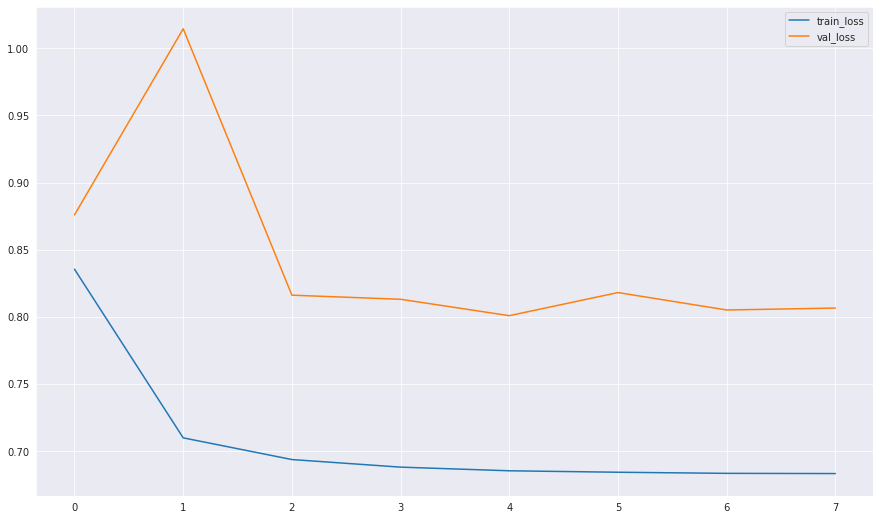

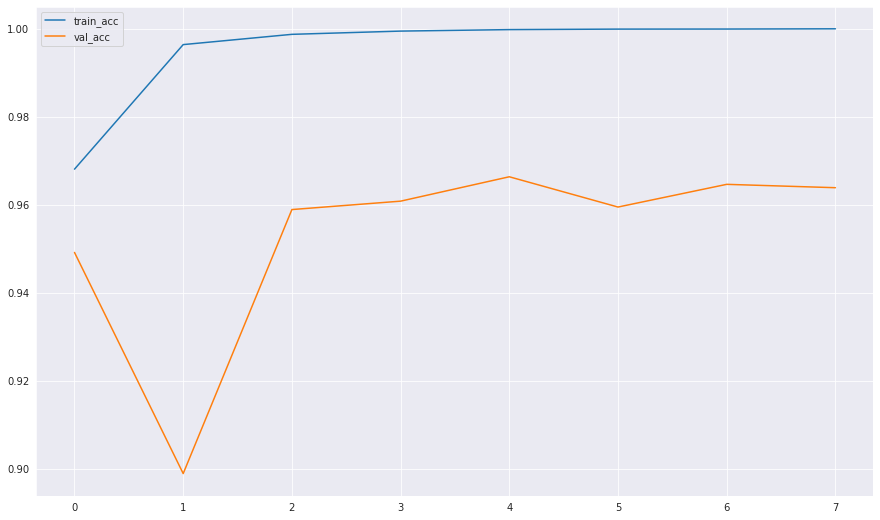

In [41]:
plt.figure(figsize=(15, 9))
plt.plot(loss_train, label="train_loss")
plt.plot(loss_val, label="val_loss")
plt.legend()
plt.show()
plt.figure(figsize=(15, 9))
plt.plot(acc_train, label="train_acc")
plt.plot(acc_val, label="val_acc")
plt.legend()
plt.show()

## Test predictions

In [42]:
classes = np.unique(train_val_labels)

test_dataset = SimpsonsDataset(test_files, 'test')
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=BATCH_SIZE)
probs = predict(resnet50, test_loader)
preds = [classes[i] for i in probs.argmax(-1)]
test_filenames = [path.name for path in test_dataset.files]

In [43]:
pd.DataFrame({
    "Id": test_filenames,
    "Expected": preds
}).to_csv("resnet50_25.csv", index=False)

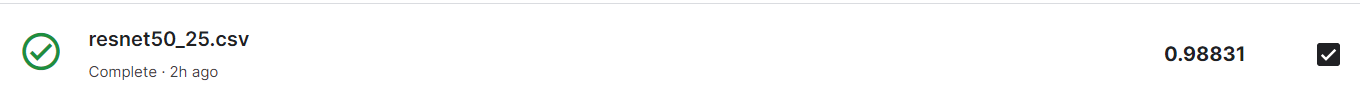

## Итог
1. Получить хороший скор - дело очень простое. Можно найти кучу работ, в которых используют базовую сеть  
и получают скор больше моего. Проблема в сети? - Нет. Проблема в тестовом датасете, который содержит 
идентичные картинки нашего треин датасета. Ну ладно, 98%, поэтому чтобы получить хороший скор 99+, делаем следующие вещи: убираем валидацию и учим сеть на всех картинках + балансировка. Балансировка может сделать
в каждом классе по 2к картинок, соответственно сеть переобучится, ну и что? У нас ведь почти весь тестовый
датасет состоит из этих картинок, поэтому проблем нет... В общем, если хотите большой скор - пожалуйста, а 
так это полный бред, не советую так делать. Я оставил валидацию, пытался различными методами бороться 
с переобучением и многому научился. Побороть переобучение у меня так и не удалось, так как если мало 
картинок, то сеть недообучается, а если много - как видите. Как я и говорил, нужно провести хороший EDA, но 
на это у меня времени не было. 
2. Очень рекомендую посмотреть этот кернел: https://www.kaggle.com/code/mihailgusev/journey-springfield-exploring, чтобы я не был голословен. Там доказано, что если написать функцию, которая способна находить 
похожие картинки, то можно применить ее к тестовому и треин датасету и спокойно получить предикты ВНИМАНИЕ! - без DL. Вот вообще ничего учить не нужно